In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.ticker as ticker
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri


In [2]:
injuryData = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/Injuries.csv")

In [3]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
injuryData.rename(columns={'Notes': 'Injury Type'}, inplace=True)
injuryData.rename(columns={'Relinquished': 'Player'}, inplace=True)

### We want to separate the dataset by year to get a good idea of the total number of injuries that have occured annually

In [4]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)



### Let's now remove all rows where the players have been acquired back from the IL 


In [5]:
# Removing the Acquired column removes all duplicates 
injuryData = injuryData[injuryData['Acquired'].isna()]
del injuryData['Acquired']

### Now let's calculate the total sum of injuries for each Year

## `It is important to note that the NBA did not have and IR/IL until the 1989-1990 season. Prior to this injured players were still members of the active roster. For this reason, it's likely many injuries do not appear in the dataset.`

In [6]:
# We only want to include data from the years after 1989 
yearly_injuries = {}
total_injuries = 0
for year, group in injuryData.groupby('Year'):
    if year > 1989: 
        injuries = group.shape[0]
        yearly_injuries[year] = injuries
        total_injuries += injuries
        
df = pd.DataFrame(yearly_injuries.items(), columns=['Year', 'Injuries'])
condition1 = df['Year'].astype(int) <= 2015
df.loc[condition1, 'Players'] = 354
df['isleagueExpansion'] = np.where(df['Year']<=2004, 0, 1)

# Set the condition for the second range of years (1996 onwards)
condition2 = df['Year'].astype(int) > 2015
df.loc[condition2, 'Players'] = 450
df['Players'] = df['Players'].astype(int)

In [7]:
# adding the total number of games played in the NBA each year to the Dataframe
def get_games_played(df):

    games_played = {
      year: 6620
      for year in range(1990, 2024)
  }

  # Update the dictionary for years with a different number of games played.
    games_played[1999] = 4100
    games_played[2011] = 4096
    games_played[2020] = 4384
    games_played[2021] = 4384

  # Create a new column in the DataFrame for the number of games played.
    df['Games Played'] = df.Year.map(games_played)
    df['Games Played'] = df['Games Played'].astype(int)

get_games_played(df)

In [8]:
# Adding feature to account for a shortened season(lockouts and COVID-19 years)
df['Shortened Season'] = np.where(df['Year'].isin([1999, 2011, 2020, 2021]), 1, 0)

In [9]:
# Add feature for average number of miles travelled year over year
# Data on travel data provided by the airball R package by Jose Fernandez (https://github.com/josedv82/airball/blob/master/README.md)
annual_travel = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/AverageTravel.csv")
df = pd.concat([df, annual_travel['Miles Traveled']], axis=1)

In [10]:
# why are there so few injuries in the early in the early 90s
# average NBA salary 


In [11]:
# turning the Players Category into binary values 
df['Players'] = df['Players'].apply(lambda x: 0 if x == 354 else 1)

In [12]:
# calculating the correlation for the two features I will use to train my model
Players_corr = df['Players'].corr(df['Injuries'])
Year_corr = df['Year'].corr(df['Injuries'])
Games_corr = df['Games Played'].corr(df['Injuries'])
Travel_corr = df['Miles Traveled'].corr(df['Injuries'])
Expansion_corr = df['isleagueExpansion'].corr(df['Injuries'])
Shortened_Season_corr = df['Shortened Season'].corr(df['Injuries'])


print("Correlation for Players feature:", Players_corr)
print("Correlation for Year feature:", Year_corr)
print("Correlation for Games Played feature:", Games_corr)
print("Correlation for Miles Traveled feature:", Travel_corr)
print("Correlation for Expansion feature:", Expansion_corr)
print("Correlation for Shortened Season feature:", Shortened_Season_corr)

Correlation for Players feature: 0.5759226257184822
Correlation for Year feature: 0.8285992890740163
Correlation for Games Played feature: -0.18779444969532763
Correlation for Miles Traveled feature: 0.1662721634969412
Correlation for Expansion feature: 0.8376745034586539
Correlation for Shortened Season feature: 0.20502095867354034


In [13]:
#Using Linear Regression function to fit our model
train_data = df[:26]

X_train = np.array(train_data[['Year', 'Players', 'Games Played', 'Miles Traveled', 'isleagueExpansion', 'Shortened Season']]).reshape(-1, 6)
y_train = train_data['Injuries']
reg = LinearRegression()


fit_model = reg.fit(X_train, y_train)
print(df.shape)
X_train.shape


(34, 7)


(26, 6)

In [14]:
# using a scikit-learn attribute, the coef represents the wieghts assigned to different features 
print(f"The Weight of feature(s): {fit_model.coef_}")

The Weight of feature(s): [ 9.75783924e+00 -2.47356248e-05  1.75219907e+02  6.26185841e-04
  4.29440066e+02  4.42048020e+05]


In [15]:
# getting the intercept(bias) for our fitted model
print(f"The Bias of the model: {fit_model.intercept_}")

The Bias of the model: -1180090.8964967509


In [16]:
# Adding our insample prediction for each year to our training data set
train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()
train_data.head()

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/1950665895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()


,Year,Injuries,Players,isleagueExpansion,Games Played,Shortened Season,Miles Traveled,prediction_insample
0,1990,64,0,0,6620,0,1292100,92.084935
1,1991,66,0,0,6620,0,1272578,89.618374
2,1992,28,0,0,6620,0,1318286,127.997915
3,1993,33,0,0,6620,0,1323961,141.309359
4,1994,127,0,0,6620,0,1320737,149.048375


In [17]:
# Calculating the error, MSE, and ABS error for each year
train_data['error'] = train_data.prediction_insample - train_data.Injuries
train_data['squared_error'] = train_data['error']**2
train_data['abs'] = abs(train_data['error'])

train_data

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/2476111573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['error'] = train_data.prediction_insample - train_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/2476111573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['squared_error'] = train_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/2476111573.py:4: SettingWithCopyWarning: 
A value is trying to be 

,Year,Injuries,Players,isleagueExpansion,Games Played,Shortened Season,Miles Traveled,prediction_insample,error,squared_error,abs
0,1990,64,0,0,6620,0,1292100,92.084935,28.084935,788.763548,28.084935
1,1991,66,0,0,6620,0,1272578,89.618374,23.618374,557.827580,23.618374
2,1992,28,0,0,6620,0,1318286,127.997915,99.997915,9999.583094,99.997915
3,1993,33,0,0,6620,0,1323961,141.309359,108.309359,11730.917318,108.309359
4,1994,127,0,0,6620,0,1320737,149.048375,22.048375,486.130858,22.048375
5,1995,245,0,0,6620,0,1330188,164.724297,-80.275703,6444.188487,80.275703
6,1996,277,0,0,6620,0,1408035,223.228825,-53.771175,2891.339214,53.771175
7,1997,290,0,0,6620,0,1433522,248.946263,-41.053737,1685.409305,41.053737
8,1998,157,0,0,6620,0,1397293,236.018016,79.018016,6243.846790,79.018016
9,1999,396,0,0,4100,1,848528,396.000000,0.000000,0.000000,0.000000


In [18]:
# I'm not sure why my error is zero 

# Returns the mean for error, squared error and absolute error for the training set
train_data[['error', 'squared_error', 'abs']].mean()

error           -5.373015e-11
squared_error    8.324525e+03
abs              7.341594e+01
dtype: float64

Text(0.5, 1.0, 'Number of Injuries Year by Year')

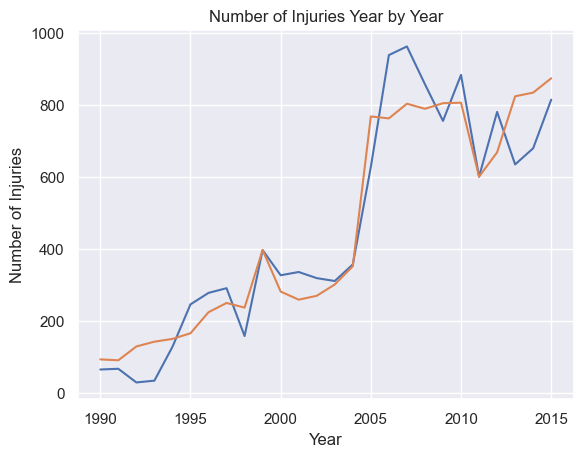

In [19]:
sns.set(style="darkgrid")
sns.lineplot(x=train_data['Year'], y=train_data['Injuries'], data=train_data)
sns.lineplot(x=train_data['Year'], y=train_data['prediction_insample'], data=train_data)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')


### <u>Time to test on a new set of data:<u>

In [20]:
test_data = df[26:]
 
X_test = np.array(test_data[['Year', 'Players', 'Games Played', 'Miles Traveled', 'isleagueExpansion', 'Shortened Season']]).reshape(-1, 6)
y_test = test_data['Injuries']
y_test

26     835
27    1172
28    1016
29     866
30     570
31    1582
32    1182
33     506
Name: Injuries, dtype: int64

In [28]:
y_pred = fit_model.predict(X_test)
print("Xtest:", X_test)
print("y_pred:", y_pred)
# Adding our insample prediction for each year to our test data set
# test_data.loc[:, 'prediction_insample'] = y_pred.copy()
# test_data.head()

Xtest: [[   2016       1    6620 1429934       1       0]
 [   2017       1    6620 1452806       1       0]
 [   2018       1    6620 1464235       1       0]
 [   2019       1    6620 1437272       1       0]
 [   2020       1    4384 1091799       1       1]
 [   2021       1    4384 1206032       1       1]
 [   2022       1    6620 1409164       1       0]
 [   2023       1    6620 1300373       1       0]]
y_pred: [  861.53849498   885.61845677   902.53297398   895.40696439
 50945.14120696 51026.43013338   907.07965047   848.71410587]


In [22]:
test_data['error'] = test_data.prediction_insample - test_data.Injuries
test_data['squared_error'] = test_data['error']**2
test_data['abs'] = abs(test_data['error'])

test_data

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/1205068349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['error'] = test_data.prediction_insample - test_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/1205068349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['squared_error'] = test_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_3485/1205068349.py:3: SettingWithCopyWarning: 
A value is trying to be set o

,Year,Injuries,Players,isleagueExpansion,Games Played,Shortened Season,Miles Traveled,prediction_insample,error,squared_error,abs
26,2016,835,1,1,6620,0,1429934,861.538495,26.538495,7.042917e+02,26.538495
27,2017,1172,1,1,6620,0,1452806,885.618457,-286.381543,8.201439e+04,286.381543
28,2018,1016,1,1,6620,0,1464235,902.532974,-113.467026,1.287477e+04,113.467026
29,2019,866,1,1,6620,0,1437272,895.406964,29.406964,8.647696e+02,29.406964
30,2020,570,1,1,4384,1,1091799,50945.141207,50375.141207,2.537655e+09,50375.141207
31,2021,1582,1,1,4384,1,1206032,51026.430133,49444.430133,2.444752e+09,49444.430133
32,2022,1182,1,1,6620,0,1409164,907.079650,-274.920350,7.558120e+04,274.920350
33,2023,506,1,1,6620,0,1300373,848.714106,342.714106,1.174530e+05,342.714106


In [23]:
df.describe()["Injuries"]

count      34.000000
mean      576.058824
std       381.342282
min        28.000000
25%       295.000000
50%       585.000000
75%       851.500000
max      1582.000000
Name: Injuries, dtype: float64

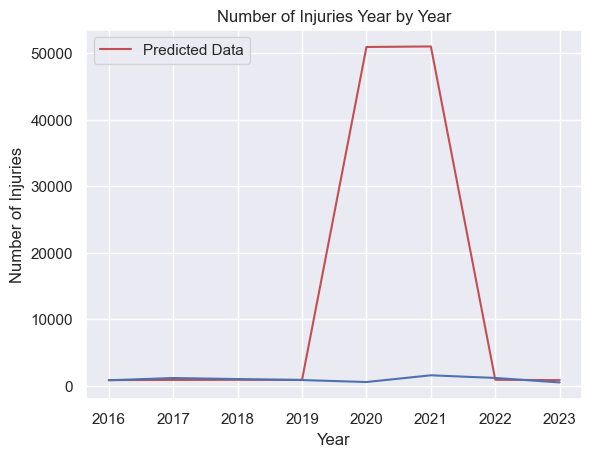

In [24]:
plt.plot(X_test[:, 0], y_pred, 'r-', label='Predicted Data')
sns.set(style="darkgrid")
sns.lineplot(x=test_data['Year'], y=test_data['Injuries'], data=test_data)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [25]:
# Now let's remove all the rows from the data frame that have data before 1990
injuryData = injuryData[injuryData['Year'] >= 1990]